<a href="https://colab.research.google.com/github/jordicastro/fsDeepLearning/blob/main/Homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import torch
import torchvision
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [63]:
def create_data_generator(batch_size = 32, root = "data"):
    # download trainable MNIST dataset
    train_dataset = torchvision.datasets.MNIST(root = root,
                                             train = True,
                                             transform = torchvision.transforms.ToTensor(),
                                             download = True)
    # download testable MNIST dataset
    test_dataset = torchvision.datasets.MNIST(root = root,
                                             train = False,
                                             transform = torchvision.transforms.ToTensor(),
                                             download = True)
    # dataset = train_dataset
    # shuffle true to ensure randomness
    # num_workers = 2 to ensure faster loading
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size = batch_size,
                                             shuffle = True)
    # not shuffled to ensure consistency during evaluation
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size = batch_size,
                                             shuffle = False)
    return train_loader, test_loader

In [64]:
class CharacterNetwork(nn.Module): # inherit from neural network module
    # TODO: change model to make it more accurate (add more convolutional layers, change num epochs, learning rate, )
    # 95% accuracy -> 99% accuracy
    def __init__(self, hidden_dims = [128]):
        super(CharacterNetwork, self).__init__()
        # self.network_dims = [28 * 28] + hidden_dims + [10]
        self.layers = []

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.flattened_size = 128 * 3 * 3
        self.network_dims = [self.flattened_size] + hidden_dims + [10]

        # Fully connected layers
        for i, dim in enumerate(self.network_dims[1:]): # iterate through network dimensions to create layers
            prev_dim = self.network_dims[i]
            dense = nn.Linear(in_features = prev_dim, out_features = dim, bias = True) # linear layer
            if i < len(self.network_dims[1:]) - 1:
                activation = nn.Sigmoid() # Hidden Layer
            else:
                activation = nn.Softmax(dim=1) # Last Layer
            self.layers += [dense, activation]

        self.layers = nn.ModuleList(self.layers)

    def forward(self, x): # forward pass TODO: add more layers for each epoch
      # input x is [B, 1, 28, 28] where B is the batch size, 1 is num channels (grayscale), 28x28 is image size

      # Convolutional layers
      # 1st layer
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.pool1(x)
      # 2nd layer
      x = self.conv2(x)
      x = self.relu2(x)
      x = self.pool2(x)
      # 3rd layer
      x = self.conv3(x)
      x = self.relu3(x)
      x = self.pool3(x)
      # Flatten
      x = x.view(x.size(0), -1)

      # Fully connected layers
      for layer in self.layers[:-1]:
        x = layer(x)
      if not self.training:
        x = self.layers[-1](x)
      return x

        # size = x.size()
        # x = x.reshape(size[0], -1) # Flatten images to [B, 28 * 28]
        # for layer in self.layers[:-1]:
        #     x = layer(x)
        # if self.training == False:
        #     x = self.layers[-1](x)
        # return x

In [65]:
cuda = torch.cuda.is_available()
batch_size = 32 # change batch size probably originally 32
train_loader, test_loader = create_data_generator(batch_size)
model = CharacterNetwork() # create an instance of the model
print(model)

AttributeError: module 'torchvision.datasets' has no attribute 'TMNIST'

In [46]:
def train(model, loader, n_epochs = 1, learning_rate = 0.1): # train the model pass in model, dataloader, number of epochs, and learning rate
    cuda = torch.cuda.is_available() # check if cuda is available
    if cuda:
        model.cuda() # move model to GPU

    optim = torch.optim.SGD(params = model.parameters(), lr = learning_rate, momentum=0.9) # initialize stochastic gradient descent optimizer
    loss_fn = nn.CrossEntropyLoss() # initialize cross entropy loss function (imported from torch.nn)
    log_losses = []
    log_accuracy = []
    model.train()

    for epoch in range(1, n_epochs + 1): # training loop for n_epochs
        for idx, (images, labels) in enumerate(loader): # iterate through the dataloader to get batches of images and labels
            if cuda:
                images = images.cuda() # move images to GPU
                labels = labels.cuda() # move labels to GPU

            outputs = model(images) # pass images through the model to get outputs

            loss = loss_fn(outputs, labels) # calculate loss)

            optim.zero_grad() # zero out / reset gradients
            loss.backward() # backpropagate -> compute gradients
            optim.step() # update weights



            predictions = torch.argmax(outputs, 1)
            accuracy = (predictions == labels).float().mean() * 100.

            loss = loss.item() # Convert to Python Scalar
            accuracy = accuracy.item() # Convert to Python Scalar
            log_losses.append(loss)
            log_accuracy.append(accuracy)

            if idx % 500 == 0: # print loss and accuracy every 500 iterations
                print("Epoch [%d/%d]. Iter [%d/%d]. Loss: %0.2f. Accuracy: %0.2f" % (epoch, n_epochs, idx + 1, len(loader), loss, accuracy))

    return model, log_losses, log_accuracy

Epoch [1/5]. Iter [1/1875]. Loss: 2.23. Accuracy: 25.00
Epoch [1/5]. Iter [501/1875]. Loss: 0.45. Accuracy: 87.50
Epoch [1/5]. Iter [1001/1875]. Loss: 0.17. Accuracy: 96.88
Epoch [1/5]. Iter [1501/1875]. Loss: 0.16. Accuracy: 90.62
Epoch [2/5]. Iter [1/1875]. Loss: 0.07. Accuracy: 100.00
Epoch [2/5]. Iter [501/1875]. Loss: 0.04. Accuracy: 96.88
Epoch [2/5]. Iter [1001/1875]. Loss: 0.04. Accuracy: 100.00
Epoch [2/5]. Iter [1501/1875]. Loss: 0.03. Accuracy: 100.00
Epoch [3/5]. Iter [1/1875]. Loss: 0.16. Accuracy: 93.75
Epoch [3/5]. Iter [501/1875]. Loss: 0.14. Accuracy: 96.88
Epoch [3/5]. Iter [1001/1875]. Loss: 0.02. Accuracy: 100.00
Epoch [3/5]. Iter [1501/1875]. Loss: 0.03. Accuracy: 96.88
Epoch [4/5]. Iter [1/1875]. Loss: 0.02. Accuracy: 100.00
Epoch [4/5]. Iter [501/1875]. Loss: 0.21. Accuracy: 90.62
Epoch [4/5]. Iter [1001/1875]. Loss: 0.02. Accuracy: 100.00
Epoch [4/5]. Iter [1501/1875]. Loss: 0.01. Accuracy: 100.00
Epoch [5/5]. Iter [1/1875]. Loss: 0.06. Accuracy: 96.88
Epoch [5/

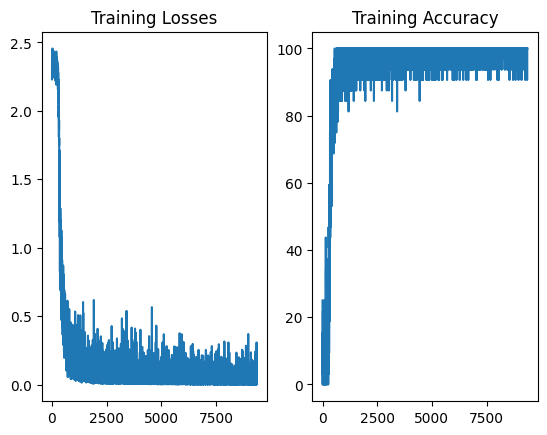

<Figure size 640x480 with 0 Axes>

In [47]:
# Training Model
model, losses, accuracies = train(model, train_loader, n_epochs = 5, learning_rate = 0.01) # change epochs, learning rate here: originally epoch=1, lr=0.1

# Saving Model
print("Saving Model to CharacterModel.pth")
torch.save(model.state_dict(), "CharacterModel.pth")

# Visualize Training Losses
fig, (ax1, ax2) = plt.subplots(1, 2)
_ = ax1.plot(losses)
_ = ax1.set_title("Training Losses")
_ = plt.figure()
_ = ax2.plot(accuracies)
_ = ax2.set_title("Training Accuracy")

In [48]:
def evaluate(model, loader): # evaluate takes in the trained model and the test_loader
    cuda = torch.cuda.is_available()
    if cuda:
        model.cuda()

    model.eval() # set model to evaluation mode
    model.load_state_dict(torch.load("CharacterModel.pth")) # load the trained model

    total_accuracy = 0.0
    for idx, (images, labels) in enumerate(test_loader): # iterate through the test_loader (test set of images and labels)
        if cuda:
            images = images.cuda() # move test images to GPU
            labels = labels.cuda() # move test labels to GPU

        outputs = model(images) # pass test images through the model to get outputs

        predictions = torch.argmax(outputs, 1) #
        accuracy = (predictions == labels).float().mean() * 100.

        accuracy = accuracy.item() # Convert to Python Scalar

        total_accuracy += accuracy

        if idx % 200 == 0:
            print("Iter [%d/%d]. Accuracy: %0.2f" % (idx + 1, len(test_loader), accuracy))

    print("Final Accuracy: %0.2f" % (total_accuracy / len(test_loader)))

In [49]:
# Evaluate Model
evaluate(model, test_loader)

<ipython-input-48-dcf563ce73d5>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth")) # load the trained model


Iter [1/313]. Accuracy: 100.00
Iter [201/313]. Accuracy: 100.00
Final Accuracy: 98.95


In [50]:
def nms(boxes, scores, threshold): # non-maximum suppression
    # non maximum supression to remove overlapping boxes (takes the most confident box)
        # boxes are of format: [x1, y1, x2, y2]
    if len(boxes) == 0:
        return []

    # Convert boxes to NumPy array
    boxes = np.array(boxes)

    # Grab the coordinates of the bounding boxes
    x1 = boxes[:, 0] # [:, 0] does what?
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Compute the area of the bounding boxes
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Sort the bounding boxes by the confidence score
    indices = np.argsort(scores)[::-1]

    pick = []

    while len(indices) > 0:
        # Grab the index of the bounding box with the highest score
        i = indices[0]
        pick.append(i)

        # Compute the intersection over union (IoU)
        xx1 = np.maximum(x1[i], x1[indices[1:]])
        yy1 = np.maximum(y1[i], y1[indices[1:]])
        xx2 = np.minimum(x2[i], x2[indices[1:]])
        yy2 = np.minimum(y2[i], y2[indices[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        iou = (w * h) / (areas[i] + areas[indices[1:]] - w * h)

        # Remove the bounding boxes with IoU greater than the threshold
        indices = np.delete(indices, np.concatenate(([0], np.where(iou > threshold)[0] + 1)))

    return pick

def find_contours(dimensions, img) : # find contours in the image, filters based on size, and applies non-maximum suppression
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check top 15 largest contours for character
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]


    target_contours = []
    img_res = []
    boxes = []
    scores = []
    for cntr in cntrs : # iterate through the contours
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :

            char_copy = np.zeros((60,40))
            # extracting each character from the image using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            # Make the aspect ratio of the detected character to be 1:2
            char = cv2.resize(char, (20, 40))
            # Padding the character to fit the size of 28x28
            char_copy[10:50, 10:30] = char

            # Reshape the character to be fed into the model
            boxes.append([intX, intY, intX+intWidth, intY+intHeight])
            scores.append(intWidth*intHeight)
            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    boxes = np.array(boxes)
    scores = np.array(scores)
    keep = nms(boxes, scores, 0.1)


    # return filtered character images and their bounding boxes coordinates
    return [img_res[i] for i in keep], [boxes[i] for i in keep]

In [51]:

def detect_characters(image_path, model): # detect and label characters in an image taking in the image path and the trained model
    # TODO: modify detect_characters to make it better
    cuda = torch.cuda.is_available()
    if cuda:
        model.cuda() # move model to GPU
    model.eval()
    model.load_state_dict(torch.load("CharacterModel.pth")) # load the trained model

    image = cv2.imread(image_path)
    image = img_lp = cv2.resize(image, (333, 75))


    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY) # convert to grayscale
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # convert to binary
    img_binary_lp = cv2.erode(img_binary_lp, (3,3)) # erosion and dialation to remove noise
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    # Get dimensions of license plate (binary image)
    LP_HEIGHT = img_binary_lp.shape[0]
    LP_WIDTH = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
        # contours are just the green boxes around the characters
    dimensions = [0, LP_WIDTH/2, LP_HEIGHT/6, 3*LP_HEIGHT/3]


    # Get contours within cropped license plate
    char_list, boxes = find_contours(dimensions, img_binary_lp)
    for idx, char in enumerate(char_list): # iterates over detected character contours
        char = cv2.resize(char, (28, 28)) # resize the character to 28x28
        char = torch.from_numpy(char).resize(1, 1, 28, 28).float() # converts to pytorch tensor to be fed into the model
        if cuda:
            char = char.cuda() # move character (represented as a tensor) to GPU

        outputs = model(char) # pass character through the model to get outputs

        pred = torch.argmax(outputs, 1)[0].item() # get the predicted character class (0-9, A-Z)
        # print(pred)

        x1, y1, x2, y2 = boxes[idx] # get the bounding box coordinates of the character
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1) # draw a green rectangle around the character (detected contour)
        image = cv2.putText(image, f'{pred}', (x1+2, y1+12), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1, cv2.LINE_AA) # put the predicted character class (ex: 'H') on the image

    # display annotated image with green boxes and their predicted classes using matplotlib
    plt.figure()
    plt.imshow(image[..., ::-1])
    plt.axis("off")


<ipython-input-51-b6281a4a9279>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("CharacterModel.pth")) # load the trained model


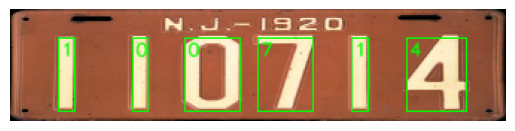

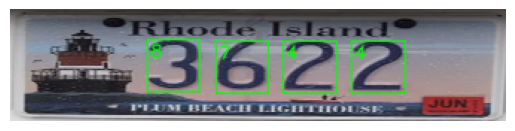

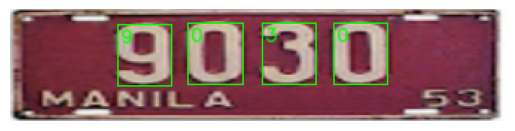

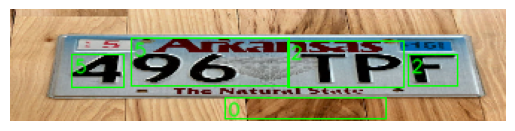

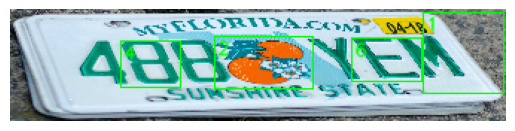

In [61]:
detect_characters("data/example1.jpeg", model)
detect_characters("data/example2.png", model)
detect_characters("data/example3.png", model)
detect_characters("data/example4.png", model)
detect_characters("data/example5.jpg", model)
